In [42]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

number_of_colors = 16

col_arr = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

In [43]:
df = pd.read_csv("/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv")
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [44]:
df.shape

(2200, 8)

In [45]:
df.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [46]:
df_mean = pd.pivot_table(df,index=['label'],aggfunc='mean')

In [47]:
phos_summary = df_mean.sort_values(by='P',ascending=False)

fig = make_subplots(rows=1, cols=2)

top_10 = { 'y': phos_summary['P'][0:10].sort_values().index,
           'x': phos_summary['P'][0:10].sort_values() 
         }

last_10 = { 'y': phos_summary['P'][-10:].sort_values().index,
           'x': phos_summary['P'][-10:].sort_values() 
         }

fig.add_trace(
                go.Bar( top_10,
                       marker_color= random.choice(col_arr),
                       name = 'Most Phosporus Required',
                       orientation = 'h',
                       text = top_10['x']
                      ),
                row=1, col=1
             )

fig.add_trace(
                go.Bar( last_10,
                       marker_color= random.choice(col_arr),
                       name = 'Least Phosporus Required',
                       orientation = 'h',
                       text = last_10['x']
                      ),
                row=1, col=2
             )

fig.update_traces(texttemplate='%{text}',textposition='inside')
fig.update_layout(title='Phosporus',font_size=12)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [48]:
fig = go.Figure()

fig.add_trace( go.Bar( x = df_mean.index,
                       y = df_mean['N'],
                      marker_color = 'brown',
                      name = 'Nitrogen'
                     )
             )

fig.add_trace( go.Bar( x = df_mean.index,
                       y = df_mean['P'],
                      marker_color = 'red',
                      name = 'Phosphorous'
                     )
             )

fig.add_trace( go.Bar( x = df_mean.index,
                       y = df_mean['K'],
                      marker_color = 'yellow',
                      name = 'Potassium'
                     )
             )
fig.update_layout(title='Comparison between different compounds')

<AxesSubplot:>

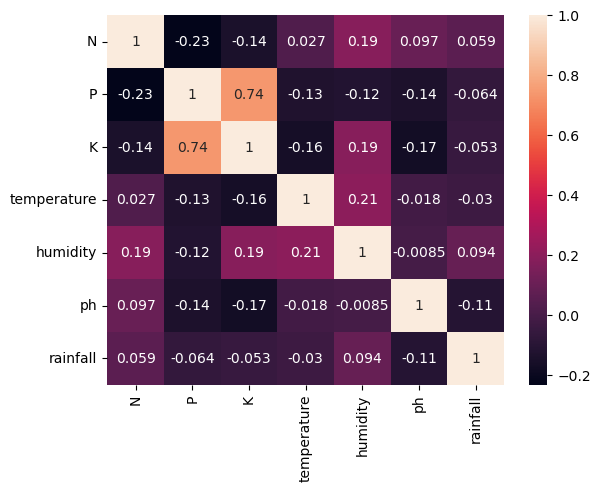

In [49]:
sns.heatmap(df.corr(),annot=True)

In [50]:
fig = px.scatter( x = df['temperature'],
                       y = df['rainfall'],
                      color = df['label'])
# fig.update_layout(title='Rainfall by temperature')
fig.show()

### K-Means Clustering/Visualisation

In [51]:
features = df.iloc[:,:-1]
features = features.astype('float64')

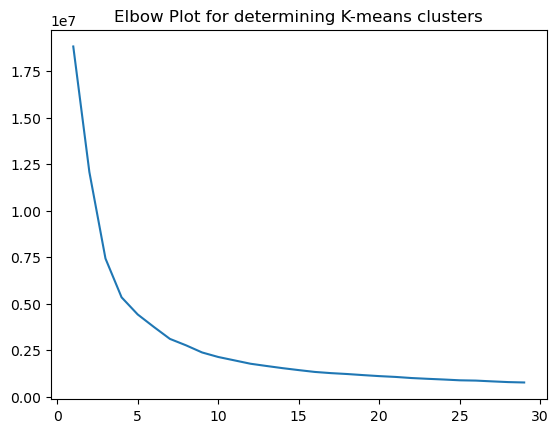

In [52]:
sse = []
for i in range(1,30):
    kmean = KMeans(n_clusters = i)
    kmean.fit(features)
    sse.append(kmean.inertia_)
plt.plot(range(1,30),sse)
plt.title("Elbow Plot for determining K-means clusters")
plt.show()

In [53]:
kmean = KMeans(n_clusters = 5)
kmean.fit(features)
clusters = kmean.labels_
df['cluster'] = clusters

In [54]:
df['labels'] = df.label.astype('category').cat.codes
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label,cluster,labels
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,0,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,0,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,0,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,0,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,0,20


In [55]:
fig = px.scatter(
    df,
    x="N",
    y="P",
    color="cluster",
    size="labels",
    symbol='labels'
).update_coloraxes(showscale=False)

fig.show()

In [56]:
for i in df.cluster.unique():
    print(df[df['cluster'] == i]['label'].value_counts())
    print("\n")

rice          100
jute          100
coffee         74
papaya         48
coconut        48
pigeonpeas     40
Name: label, dtype: int64


banana        100
watermelon    100
muskmelon     100
cotton        100
maize          77
coffee         22
papaya         16
Name: label, dtype: int64


pomegranate    100
orange         100
mango           98
coconut         52
pigeonpeas      44
kidneybeans     36
papaya          21
maize            7
coffee           4
Name: label, dtype: int64


chickpea       100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
kidneybeans     64
maize           16
pigeonpeas      16
papaya          15
mango            2
Name: label, dtype: int64


grapes    100
apple     100
Name: label, dtype: int64




### Logistic Regression Model

In [57]:
X = features
y = df['labels']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [58]:
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [59]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)

In [60]:
df_test = pd.DataFrame()
df_test['actual_label'] = y_test
df_test['pred_label'] = y_pred
df_test.head(10)

,actual_label,pred_label
1030,1,1
1032,1,1
1437,15,15
2052,8,8
1698,16,16
1608,16,16
329,9,9
1474,15,15
874,10,10
276,3,3


In [61]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_pred, y_test)
print('Simple Logistic Regression Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Simple Logistic Regression Model accuracy score: 0.9788


In [62]:
classes = list(set(df['label']))
classes

['kidneybeans',
 'banana',
 'jute',
 'pomegranate',
 'grapes',
 'papaya',
 'rice',
 'coconut',
 'lentil',
 'coffee',
 'pigeonpeas',
 'mothbeans',
 'mango',
 'orange',
 'maize',
 'blackgram',
 'watermelon',
 'chickpea',
 'apple',
 'cotton',
 'mungbean',
 'muskmelon']

In [63]:
set(df['labels'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}

In [64]:
label = int(log_reg.predict([[90, 42, 43, 20.879744, 75, 5.5,220]]))
label

20